In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.image import imread
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Rectangle

import cv2
import pickle

In [2]:
import matplotlib.pyplot as plt 
plt.rcParams.update({
    "font.family" : 'Arial',   # specify font family here
    "font.size" : 12,
    "font.weight" : "normal"})          # specify font size here

In [3]:
file_info = pd.read_csv('/home/jinny/projects/Art-history/Art-history/datas/file_info.csv')
avec = np.load('/home/jinny/projects/Art-history/Art-history/datas/vectors/avec_latents.npy', allow_pickle=True)

# file_info_latent
df = pd.DataFrame((avec),columns=['latent','Path'])
file_info_latents = pd.merge(file_info, df, how = 'left', on = 'Path')
file_info_latents = file_info_latents[~file_info_latents.latent.isnull()]

avec = np.array([i.reshape(-1) for i in file_info_latents['latent']])

In [4]:
file_info['new_date'].value_counts()[-30:]
paintings = dict()
for i in [1500,1600,1700,1800,1900] :
    years = [i+j*10 for j in range(10)]
    paintings[i] = len(file_info[file_info['new_date'].isin(years)])

/tmp/ipykernel_2807885/3710271364.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  file_info['new_date'].value_counts()[-30:]


## 00. EDA

In [5]:
file_info_latents_1500 = file_info_latents[file_info_latents['new_date']>=1]

In [6]:
print('Painting total :',len(file_info_latents_1500))

Painting total : 73814


In [7]:
df_style_temp = file_info_latents_1500[['Style']]
df_style_temp['Style'] = df_style_temp['Style'].fillna('')
df_style_temp['new_style'] = df_style_temp['Style'].str.split(',')
df_style_temp = df_style_temp.explode('new_style')

print('Style period total :', df_style_temp['new_style'].nunique())

Style period total : 129


/tmp/ipykernel_2807885/1478874313.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_style_temp['Style'] = df_style_temp['Style'].fillna('')
/tmp/ipykernel_2807885/1478874313.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_style_temp['new_style'] = df_style_temp['Style'].str.split(',')


In [8]:
df_artist_temp = file_info_latents_1500[['author_name']]
df_artist_temp['author_name'] = df_artist_temp['author_name'].fillna('')
df_artist_temp['new_author_name'] = df_artist_temp['author_name'].str.split(',')
df_artist_temp = df_artist_temp.explode('new_author_name')

print('Artist total :', df_artist_temp['new_author_name'].nunique())

/tmp/ipykernel_2807885/4264408358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_artist_temp['author_name'] = df_artist_temp['author_name'].fillna('')


Artist total : 2401


/tmp/ipykernel_2807885/4264408358.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_artist_temp['new_author_name'] = df_artist_temp['author_name'].str.split(',')


In [9]:
df_nationality_temp = file_info_latents_1500[['Nationality']]
df_nationality_temp['Nationality'] = df_nationality_temp['Nationality'].fillna('')
df_nationality_temp['new_nationality'] = df_nationality_temp['Nationality'].str.split(',')
df_nationality_temp = df_nationality_temp.explode('new_nationality')

print('Nationality total :', df_nationality_temp['new_nationality'].nunique())

/tmp/ipykernel_2807885/4077375958.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nationality_temp['Nationality'] = df_nationality_temp['Nationality'].fillna('')


Nationality total : 64


/tmp/ipykernel_2807885/4077375958.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nationality_temp['new_nationality'] = df_nationality_temp['Nationality'].str.split(',')


## 01.statistics

/tmp/ipykernel_2807885/3181340830.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(ax[i].get_yticklabels(),size=32)


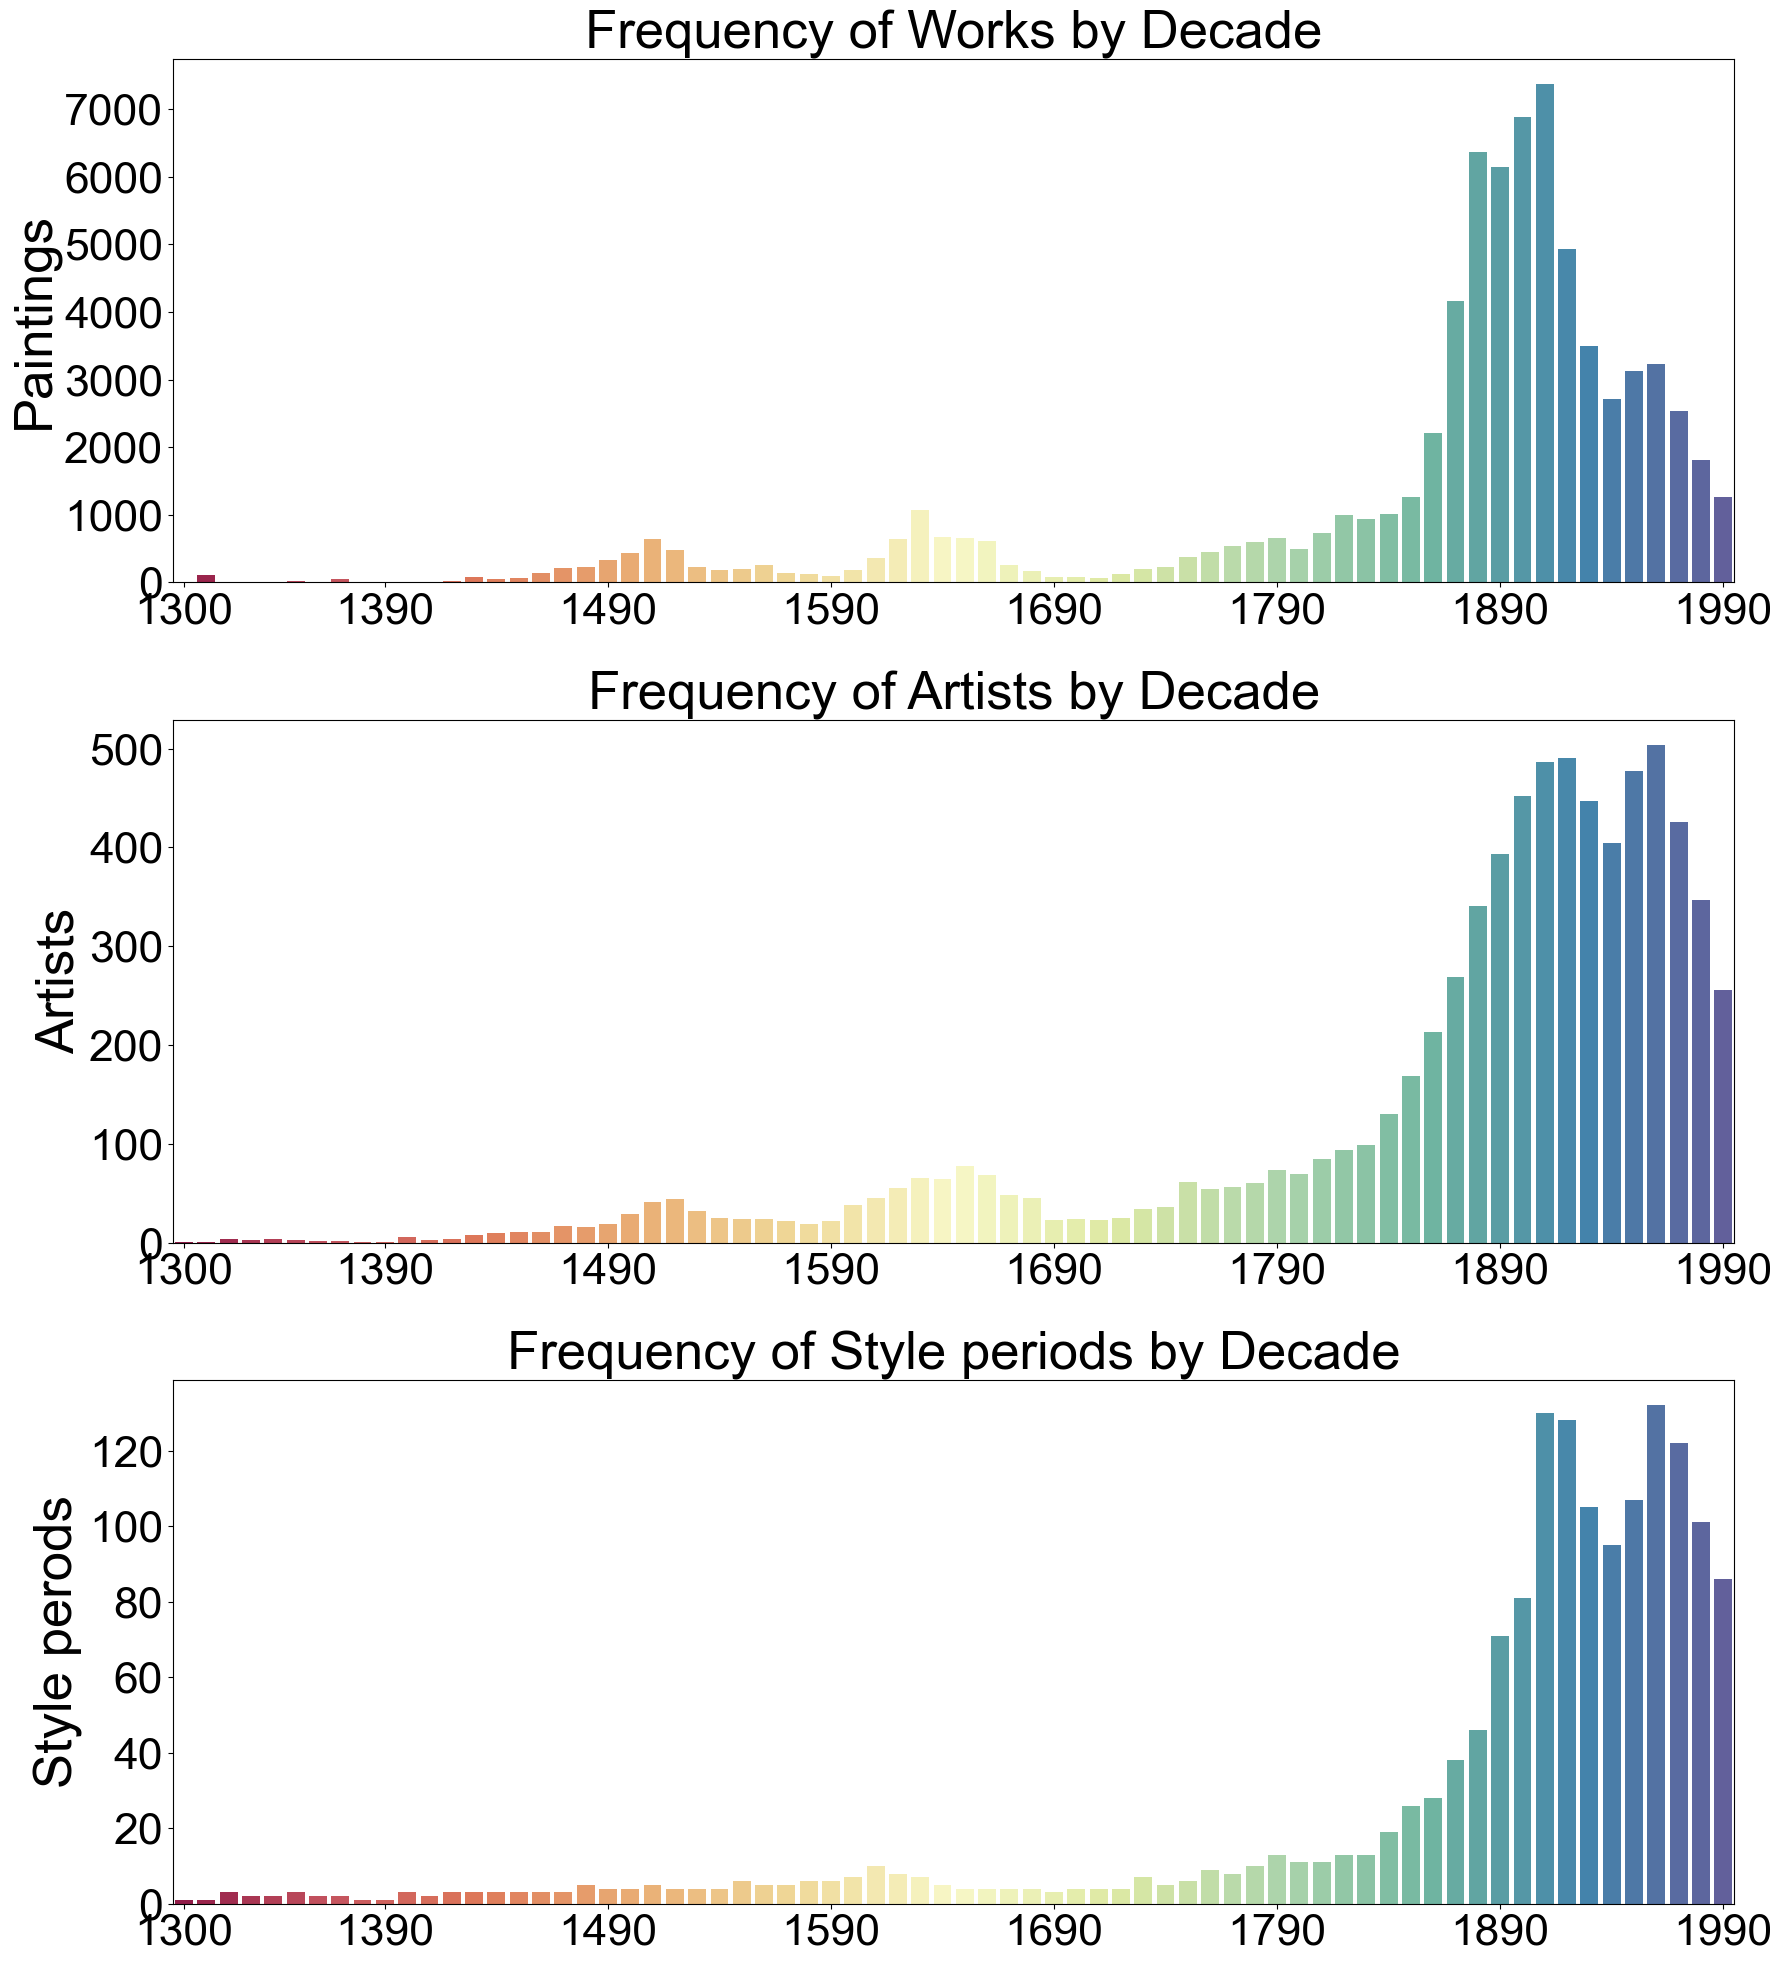

In [10]:
fig, ax = plt.subplots(3,1,figsize=(18, 20))
ax = ax.reshape(-1)

sns.countplot(x='new_date', data=file_info, order = sorted(file_info['new_date'].unique()), ax = ax[0],palette='Spectral' )
ax[0].set_ylabel("Paintings",size=38)
ax[0].set_title('Frequency of Works by Decade',size=38)

sns.countplot(x='new_date', data=file_info.drop_duplicates(subset=['new_date','author_name']), ax = ax[1],palette='Spectral')
ax[1].set_ylabel("Artists",size=38)
ax[1].set_title("Frequency of Artists by Decade",size=38)

sns.countplot(x='new_date', data=file_info.drop_duplicates(subset=['new_date','Style']), ax = ax[2],palette='Spectral')
ax[2].set_ylabel("Style perods",size=38)
ax[2].set_title("Frequency of Style periods by Decade",size=38)

for i in range(3) :
    ax[i].set_xlabel(" ")
    ax[i].set_yticklabels(ax[i].get_yticklabels(),size=32)
    ax[i].set_xticklabels(ax[i].get_xticklabels(),size=32)
    ax[i].set_xticks([0,9,19,29,39,49,59,69])

plt.tight_layout()
plt.savefig(f'/home/jinny/projects/Art-history/Art-history/graph/supple/si01.svg')

In [19]:
#스타일 가중치 계산 및 대표 년도 추가
df_newstyle = file_info['Style'].str.split(',', expand=True)
df_newstyle = df_newstyle.melt(value_name='Style', ignore_index=False).dropna().drop(columns='variable')

temp = file_info[['new_date','Style','painting_name']].drop(columns='Style').join(df_newstyle, how='left')
temp['Weight'] = 1 / (temp.groupby('painting_name')['Style'].transform('count'))

df_newstyle = temp.dropna(subset=['Style'])

temp = df_newstyle.groupby('Style')['new_date'].agg(lambda x: x.mode().iloc[0]).reset_index()
temp.rename(columns={'new_date': 'Peak_year'}, inplace=True)

df_newstyle = df_newstyle.merge(temp, on='Style', how='left')

style_peak_year = df_newstyle[['Style','Peak_year']]
style_peak_year = style_peak_year.drop_duplicates()

new_style = list()
for i in df_newstyle['Style'] :
    year = style_peak_year['Peak_year'][style_peak_year['Style']==i].values[0]
    new_style.append(f'{i} ({year})')
df_newstyle['Style_Peak_year'] = new_style

/tmp/ipykernel_2807885/3236663979.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(ax[i].get_yticklabels(),size=28)
/tmp/ipykernel_2807885/3236663979.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(ax[i].get_xticklabels(),size=28)


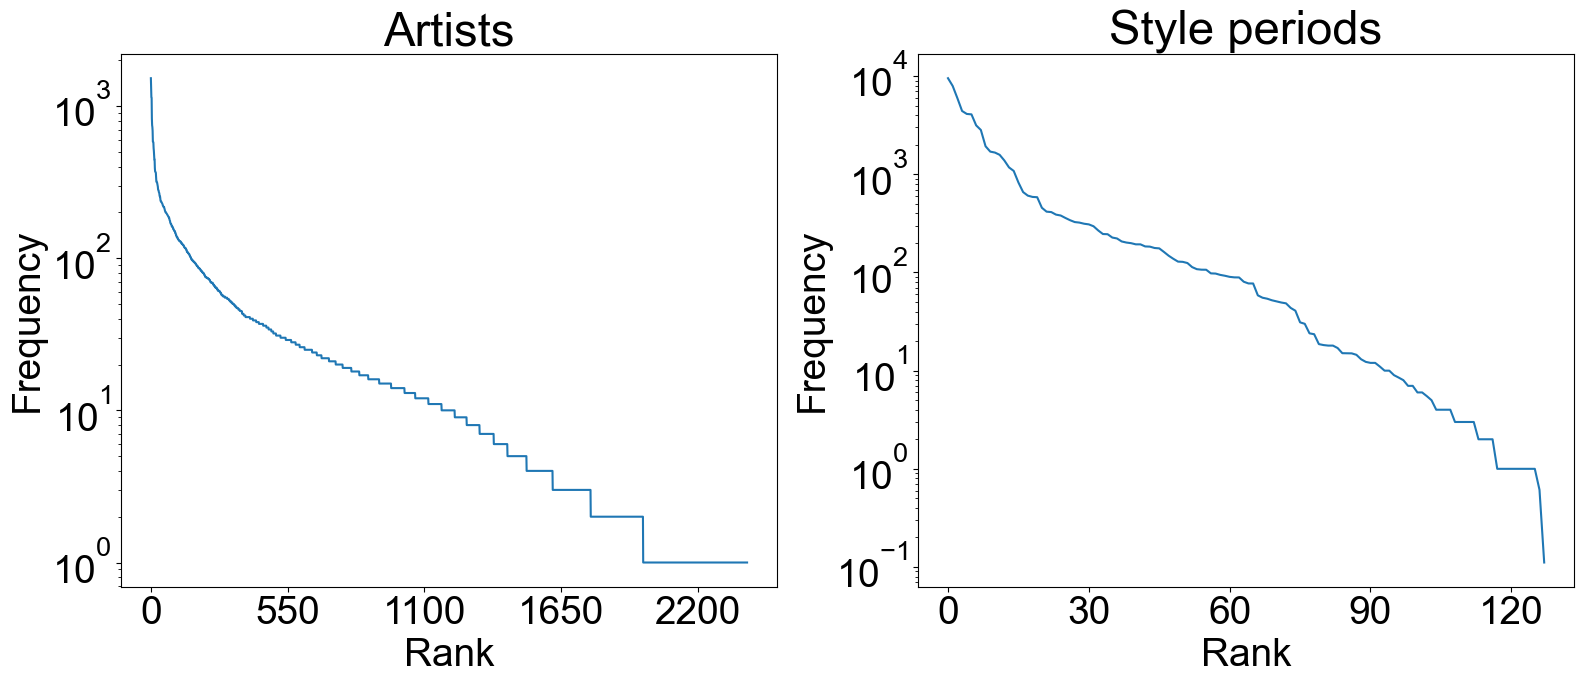

In [52]:
fig, ax = plt.subplots(1,2,figsize=(16,7))
ax = ax.reshape(-1)

temp = file_info.groupby('author_name')[['painting_name']].count().sort_values('painting_name',ascending=False)
ax[0].plot(temp)
ax[0].set_title('Artists',size=34)

temp = df_newstyle.groupby('Style')[['Weight']].sum().sort_values('Weight',ascending=False)
ax[1].plot(temp)
ax[1].set_title('Style periods',size=34)

for i in range(2) :
    ax[i].set_xlabel('Rank',size=28)
 
    ax[i].set_ylabel('Frequency',size=28)
    ax[i].set_yscale('log')
    ax[i].set_yticklabels(ax[i].get_yticklabels(),size=28)
    ax[i].set_xticklabels(ax[i].get_xticklabels(),size=28)
ax[0].set_xticks(np.arange(0,2500,550),labels=np.arange(0,2500,550),size=28)
ax[1].set_xticks(np.arange(0,135,30),labels=np.arange(0,135,30),size=28)
plt.tight_layout() 
plt.savefig(f'/home/jinny/projects/Art-history/Art-history/graph/supple/si02.svg')

In [55]:
new_style = list()
for i in df_newstyle['Style'] :
    year = style_peak_year['Style_Peak_year'][style_peak_year['Style']==i].values[0]
    new_style.append(f'{i} ({year})')

df_newstyle['new_style'] = new_style

temp = df_newstyle[['Style_Peak_year','Weight']].groupby('Style_Peak_year').sum()
temp = temp.sort_values(by='Weight', ascending=False)[:10].reset_index()

/tmp/ipykernel_2807885/4000225015.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),size=20)


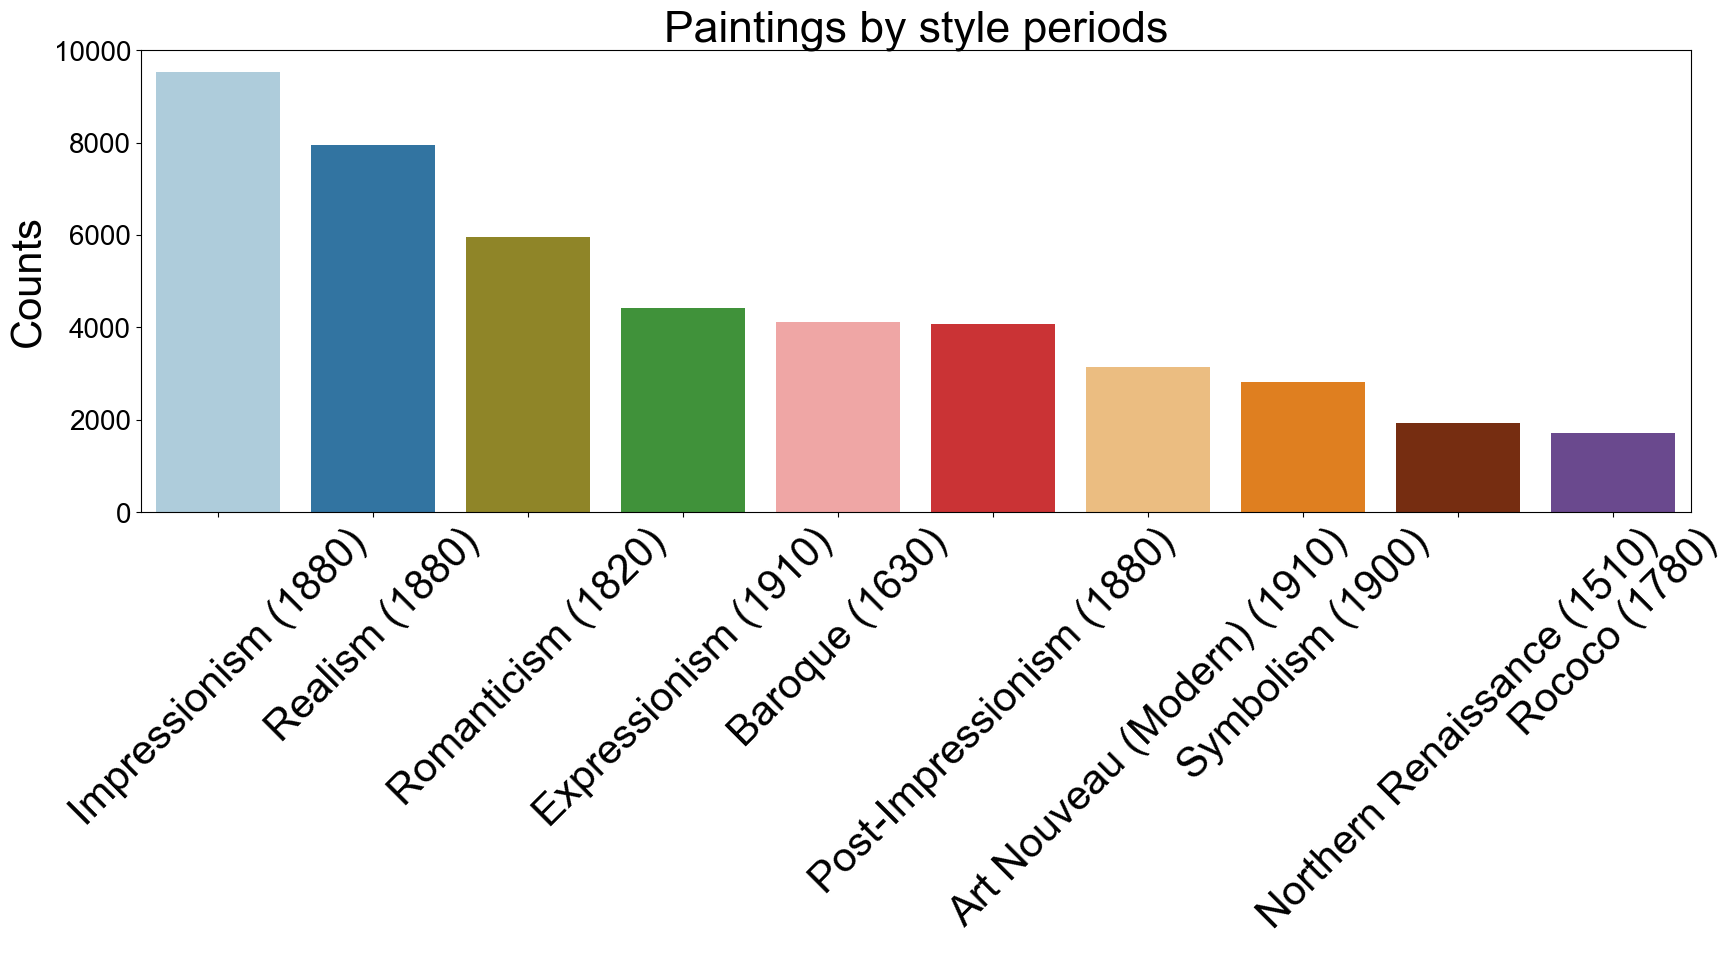

In [57]:
plt.figure(figsize=(20,6))
ax = sns.barplot(x='Style_Peak_year',y='Weight', data=temp ,palette='Spectral')
ax.set_ylabel("Counts",size=30)
ax.set_xlabel(" ")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,size=30)
ax.set_yticklabels(ax.get_yticklabels(),size=20)
ax.set_title("Paintings by style periods",size=32)
plt.savefig(f'/home/jinny/projects/Art-history/Art-history/graph/supple/si03a.svg')
plt.show()

In [29]:
#target_authors = [['Albrecht Durer (1471-1528)','albrecht durer'],['Rembrandt (1606-1669)','rembrandt'],['Johannes Vermeer (1632-1675)','johannes vermeer'],['Jean-Francois Millet (1814-1875)','jean-francois millet'],['Edouard Manet (1832-1883)','edouard manet'],['Paul Cezanne (1839-1906)','paul cezanne'],['Pierre-Auguste Renoir (1841-1919)','pierre auguste renoir'],['Vincent van Gogh (1853-1890)','vincent van gogh'],['Gustav Klimt (1862-1918)','gustav klimt'],['Egon Schiele (1890-1918)','egon schiele']]
target_authors = [['Albrecht Durer (1528)','albrecht durer'],['Rembrandt (1669)','rembrandt'],['Johannes Vermeer (1675)','johannes vermeer'],['Jean-Francois Millet (1875)','jean-francois millet'],['Edouard Manet (1883)','edouard manet'],['Paul Cezanne (1906)','paul cezanne'],['Pierre-Auguste Renoir (1919)','pierre auguste renoir'],['Vincent van Gogh (1890)','vincent van gogh'],['Gustav Klimt (1918)','gustav klimt'],['Egon Schiele (1918)','egon schiele']]

target_authors_dic = {i[1]:i[0] for i in target_authors}

df_umap_author10 = file_info[file_info['author_name'].isin(target_authors_dic.keys())]
df_umap_author10['author_name_year'] = [target_authors_dic[i] for i in df_umap_author10['author_name'] ]

/tmp/ipykernel_1662997/1630647413.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_umap_author10['author_name_year'] = [target_authors_dic[i] for i in df_umap_author10['author_name'] ]


/tmp/ipykernel_1662997/3524252432.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(),size=20)


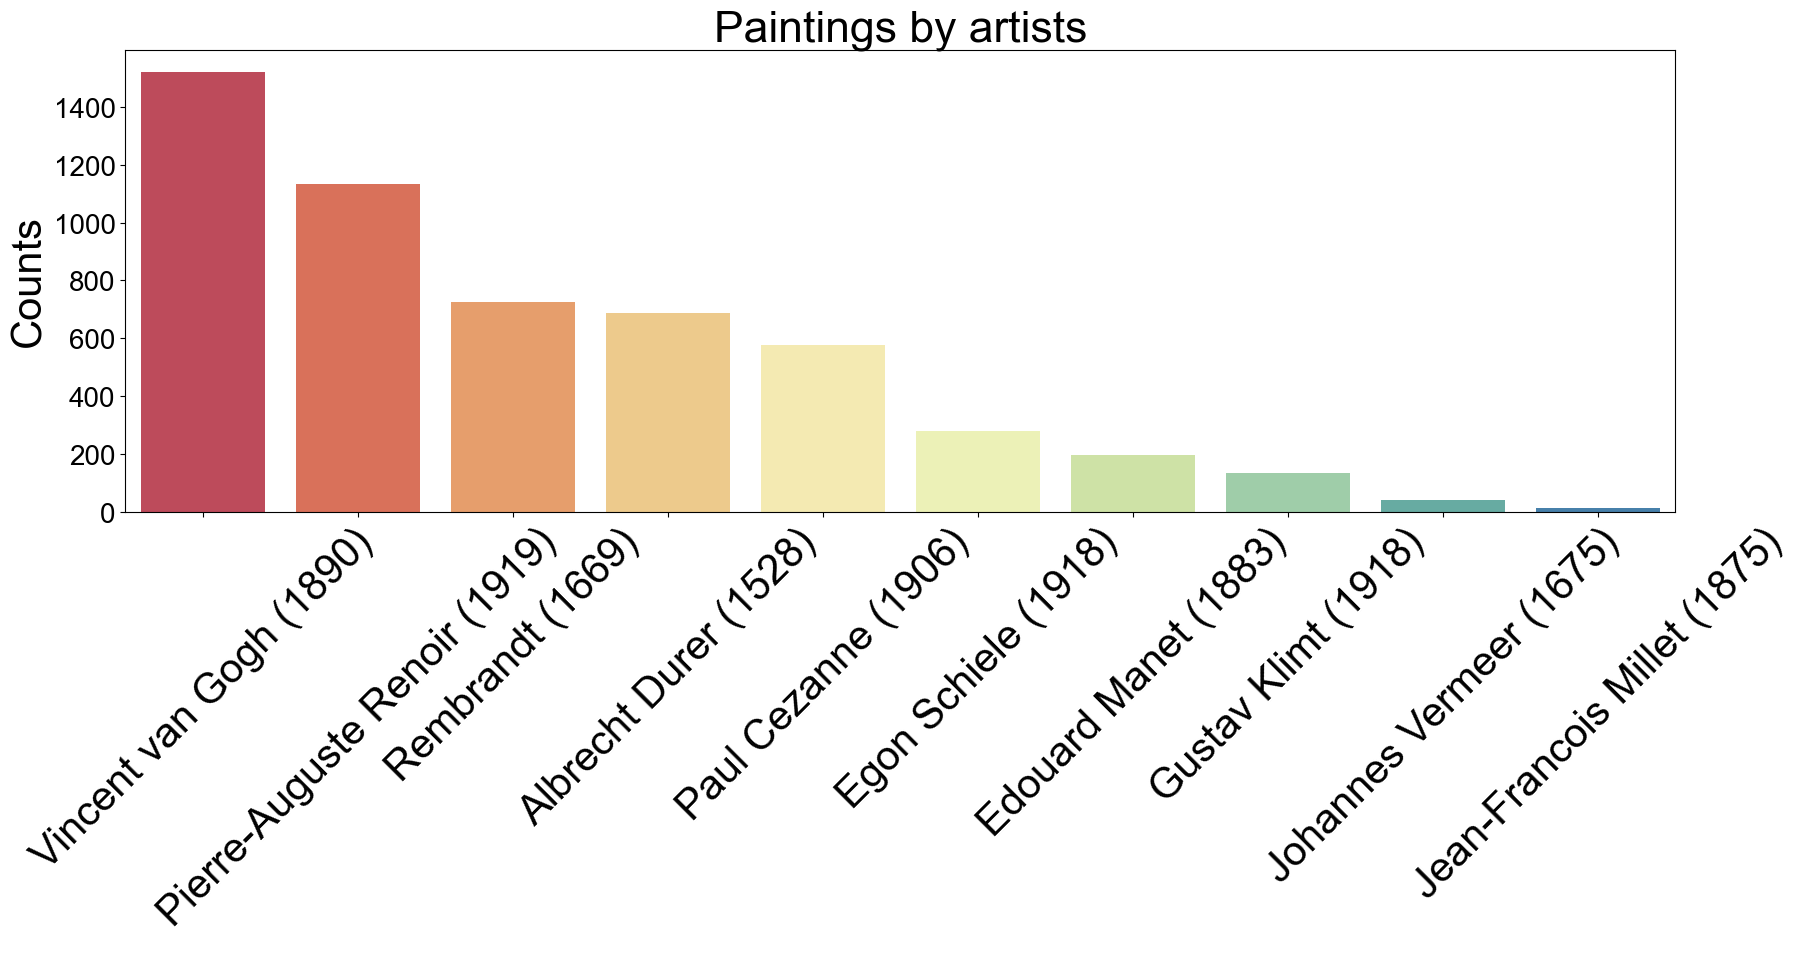

In [37]:
plt.figure(figsize=(20,6))
temp = df_umap_author10
ax = sns.countplot(x='author_name_year', data=temp, order = temp['author_name_year'].value_counts()[:10].index ,palette='Spectral')
ax.set_ylabel("Counts",size=30)
ax.set_xlabel(" ")
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,size=30)
ax.set_yticklabels(ax.get_yticklabels(),size=20)
ax.set_title("Paintings by artists",size=32)
plt.savefig(f'/home/jinny/projects/Art-history/Art-history/graph/supple/si03b.svg')
plt.show()

## 02. prompt smaple

In [1]:
import os
os.chdir("scripts")

In [2]:
import argparse, os
import PIL
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange, repeat
from torchvision.utils import make_grid
from torch import autocast
from contextlib import nullcontext
from pytorch_lightning import seed_everything
from imwatermark import WatermarkEncoder
import pandas as pd
from scripts.txt2img import put_watermark
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.image import imread

/home/jinny/anaconda3/envs/history/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [3]:
def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    if "global_step" in pl_sd:
        print(f"Global Step: {pl_sd['global_step']}")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.cuda()
    model.eval()
    return model

def load_model(device_num) :
    base_path = '/home/jinny/projects/Art-history/Art-history/'
    config = OmegaConf.load(base_path+f"scripts/configs/stable-diffusion/v2-inference.yaml")
    model = load_model_from_config(config, base_path+f"scripts/configs/checkpoint/512-base-ema.ckpt") 

    GPU_NUM = device_num # 원하는 GPU 번호 입력
    
    # GPU 할당 변경하기
    device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
    torch.cuda.set_device(device) # change allocation of current GPU
    print ('Current cuda device ', torch.cuda.current_device()) # check
    
    model = model.to(device)
    return model,device

def load_img(path):
    image = Image.open(path).convert("RGB")
    w, h = image.size
    print(f"loaded input image of size ({w}, {h}) from {path}")
    w, h = map(lambda x: x - x % 64, (w, h))  # resize to integer multiple of 64
    image = image.resize((w, h), resample=PIL.Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2. * image - 1.

In [4]:
def diffusion_txt2img(model,device,from_file,prompt,negative_prompts,seed):
    seed = seed
    seed_everything(seed)

    #sampler = PLMSSampler(model)
    #sampler = DPMSolverSampler(model)
    sampler = DDIMSampler(model)

    n_samples = 1
    batch_size = n_samples
    n_rows = 1
    repeat = 1
    
    if not from_file:
        print(f"prompt - {prompt}")
        prompt = prompt
        assert prompt is not None
        data = [batch_size * [prompt]]
    else:
        print(f"reading prompts from {from_file}")
        with open(from_file, "r") as f:
            data = f.read().splitlines()
            data = [p for p in data for i in range(repeat)]
            data = list(chunk(data, batch_size))

    start_code = None
    #start_code = torch.randn([1,4, 512 // 8, 512 // 8], device=device)

    precision_scope = autocast 
    n_iter = 1
    scale = 9.0
    steps = 40
    ddim_eta = 0
    C,H,W = 4,512,512
    f = 8
    with torch.no_grad(), \
        precision_scope("cuda"), \
        model.ema_scope():
            all_samples = list()
            for n in trange(n_iter, desc="Sampling"):
                for prompts in tqdm(data, desc="data"):
                    uc = None
                    if scale != 1.0:
                        uc = model.get_learned_conditioning(batch_size * [negative_prompts])
                    if isinstance(prompts, tuple):
                        prompts = list(prompts)
                    c = model.get_learned_conditioning(prompts)
                    new_c = list()
                    new_c.append(c)
                    shape = [C, H//8, W//8]
                    samples, _ = sampler.sample(S=steps,
                                                     conditioning=c,
                                                     batch_size=n_samples,
                                                     shape=shape,
                                                     verbose=False,
                                                     unconditional_guidance_scale=scale,
                                                     unconditional_conditioning=uc,
                                                     eta=ddim_eta,
                                                     x_T=start_code)

                    # x_samples = model.decode_first_stage(samples)
                    # x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)
                    #all_samples.append(x_samples[0])
                    #all_samples_enc.append(samples[0])
               
    return samples,new_c,prompts

In [5]:
def model_2img(latent_samples, model) :
    precision_scope = autocast 
    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                
                x_samples = model.decode_first_stage(latent_samples)
                x_samples = torch.clamp((x_samples + 1.0) / 2.0, min=0.0, max=1.0)

                for x_sample in x_samples:
                    x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                    img = Image.fromarray(x_sample.astype(np.uint8))
                    #img = put_watermark(img, wm_encoder)
                    return img
                    # plt.imshow(img)
                    # plt.show()

In [6]:
# model load
model,device = load_model(1)

Loading model from /home/jinny/projects/Art-history/Art-history/scripts/configs/checkpoint/512-base-ema.ckpt
Global Step: 875000
LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientC

In [7]:
prompts = pd.read_csv('/home/jinny/projects/Art-history/Art-history/datas/prompts.csv')

In [8]:
samples = ['Allegretto Nuzi/Crucifixion','William Simpson/The Petroleum', 'Jan Steen/Worship' ]
sample_paths = [prompts['Path'][prompts['Path'].str.contains(i)].values[0] for i in samples]

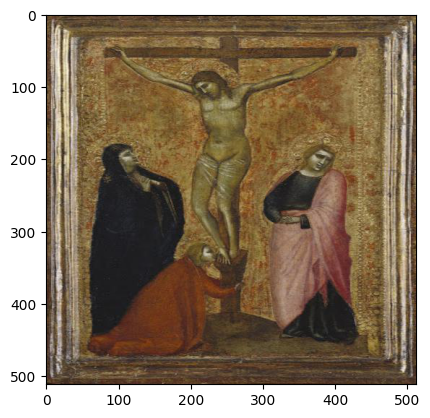

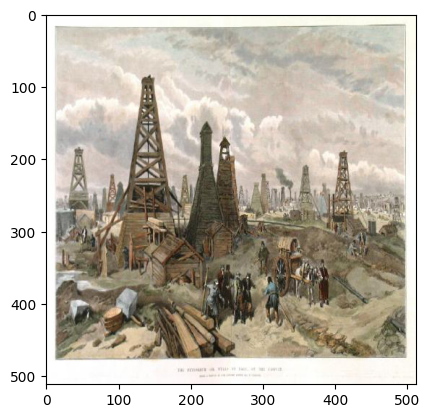

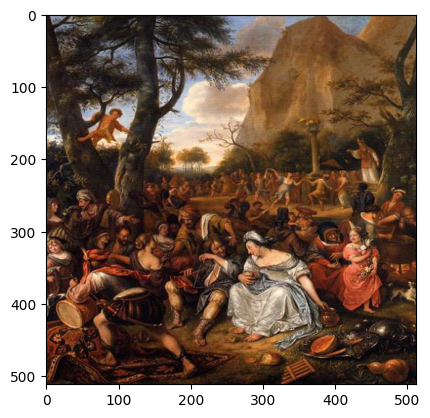

In [9]:
for path in sample_paths :
    img_test = img.imread(f'/home/jinny/projects/Art-history/02_image_resize/output/{path}')
    plt.imshow(img_test)
    plt.show()

In [10]:
from_file = ''
negative_prompt = ''
prompt_diffusion = {}
for path in sample_paths :
    prompt = prompts['prompts'][prompts['Path']==path].values[0]
    x_samples = diffusion_txt2img(model,device,from_file,prompt,negative_prompt,19980727)
    prompt_diffusion[path] = x_samples

Global seed set to 19980727


prompt - a painting of a crucif with three women and a man, fine-art, 🔞🤡, italian masterpieces, artststion, fuller, gory, samsara, gallows, album, vincent, sienna, springtime, brazilian, fotografia, kami, banner, winning photo


data:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 40 timesteps




DDIM Sampler:   0%|                                                                              | 0/40 [00:00<?, ?it/s]

DDIM Sampler:   2%|█▊                                                                    | 1/40 [00:01<00:43,  1.11s/it]

DDIM Sampler:   8%|█████▎                                                                | 3/40 [00:01<00:12,  2.90it/s]

DDIM Sampler:  12%|████████▊                                                             | 5/40 [00:01<00:07,  4.81it/s]

DDIM Sampler:  18%|████████████▎                                                         | 7/40 [00:01<00:05,  6.53it/s]

DDIM Sampler:  22%|███████████████▊                                                      | 9/40 [00:01<00:03,  8.02it/s]

DDIM Sampler:  28%|██████████████████▉                                                  | 11/40 [00:01<00:03,  9.23it/s]

DDIM Sampler:  32%|██████████████████████▍                                              | 13/40 [00:02<00:02, 10.20it/s]

DDIM Sampler:  38%|███

prompt - there are many people walking around a large oil well, 1 9 century, ruined cities, chicago, pylons, 6 4 0, w 1024, the fashion of the time, lots of diamonds unearthed, chinese village, bizarrrrre, west slav features, oil slick


data:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 40 timesteps




DDIM Sampler:   0%|                                                                              | 0/40 [00:00<?, ?it/s]

DDIM Sampler:   5%|███▌                                                                  | 2/40 [00:00<00:03, 12.52it/s]

DDIM Sampler:  10%|███████                                                               | 4/40 [00:00<00:02, 12.73it/s]

DDIM Sampler:  15%|██████████▌                                                           | 6/40 [00:00<00:02, 12.83it/s]

DDIM Sampler:  20%|██████████████                                                        | 8/40 [00:00<00:02, 12.86it/s]

DDIM Sampler:  25%|█████████████████▎                                                   | 10/40 [00:00<00:02, 12.87it/s]

DDIM Sampler:  30%|████████████████████▋                                                | 12/40 [00:00<00:02, 13.01it/s]

DDIM Sampler:  35%|████████████████████████▏                                            | 14/40 [00:01<00:01, 13.11it/s]

DDIM Sampler:  40%|███

prompt - a painting of a group of people in a wooded area, epic scene of zeus, revellers, dutch, background of invading army, cute woman, wikimedia commons, joseph maria olbrich, realistic scene, river of wine, accurate depiction, contemporary art


data:   0%|                                                                                       | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0
Running DDIM Sampling with 40 timesteps




DDIM Sampler:   0%|                                                                              | 0/40 [00:00<?, ?it/s]

DDIM Sampler:   5%|███▌                                                                  | 2/40 [00:00<00:02, 12.91it/s]

DDIM Sampler:  10%|███████                                                               | 4/40 [00:00<00:02, 13.14it/s]

DDIM Sampler:  15%|██████████▌                                                           | 6/40 [00:00<00:02, 13.22it/s]

DDIM Sampler:  20%|██████████████                                                        | 8/40 [00:00<00:02, 13.26it/s]

DDIM Sampler:  25%|█████████████████▎                                                   | 10/40 [00:00<00:02, 13.28it/s]

DDIM Sampler:  30%|████████████████████▋                                                | 12/40 [00:00<00:02, 13.29it/s]

DDIM Sampler:  35%|████████████████████████▏                                            | 14/40 [00:01<00:01, 13.30it/s]

DDIM Sampler:  40%|███

a painting of a crucif with three women and a man, fine-art, 🔞🤡, italian masterpieces, artststion, fuller, gory, samsara, gallows, album, vincent, sienna, springtime, brazilian, fotografia, kami, banner, winning photo
< artist - allegretto nuzi ---- painting name - Crucifixion With The Virgin Mary St John The Evangelist And St Mary Magdalene##zQF7UXMNo41WiQ>
there are many people walking around a large oil well, 1 9 century, ruined cities, chicago, pylons, 6 4 0, w 1024, the fashion of the time, lots of diamonds unearthed, chinese village, bizarrrrre, west slav features, oil slick
< artist - william simpson ---- painting name - The Petroleum Oil Wells At Baku On The Caspian 1886>
a painting of a group of people in a wooded area, epic scene of zeus, revellers, dutch, background of invading army, cute woman, wikimedia commons, joseph maria olbrich, realistic scene, river of wine, accurate depiction, contemporary art
< artist - jan steen ---- painting name - Worship Of Golden Calf 1677>


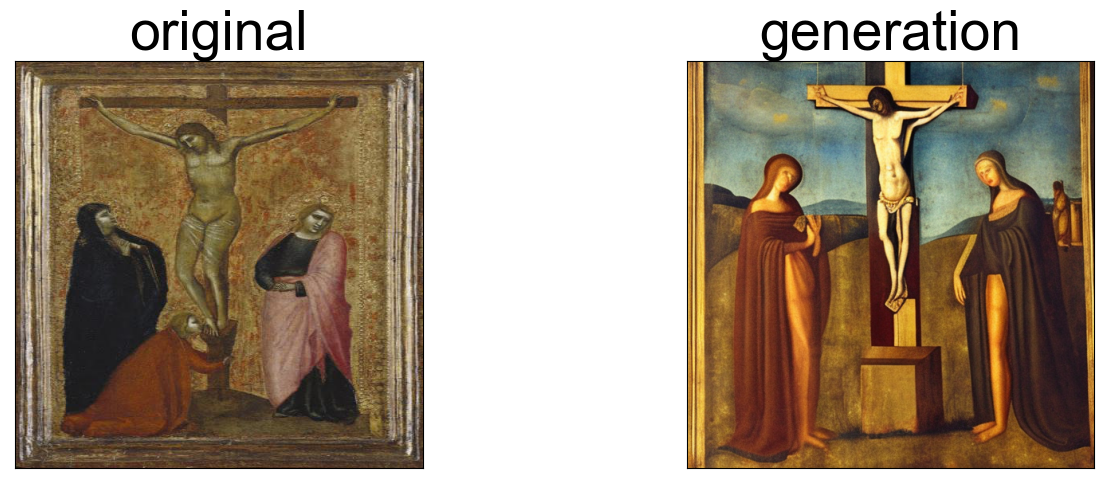

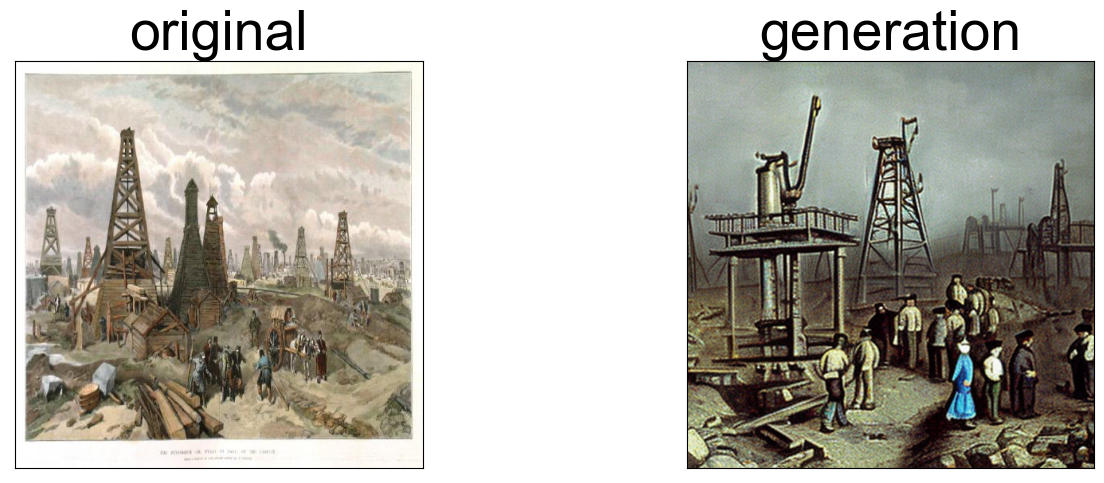

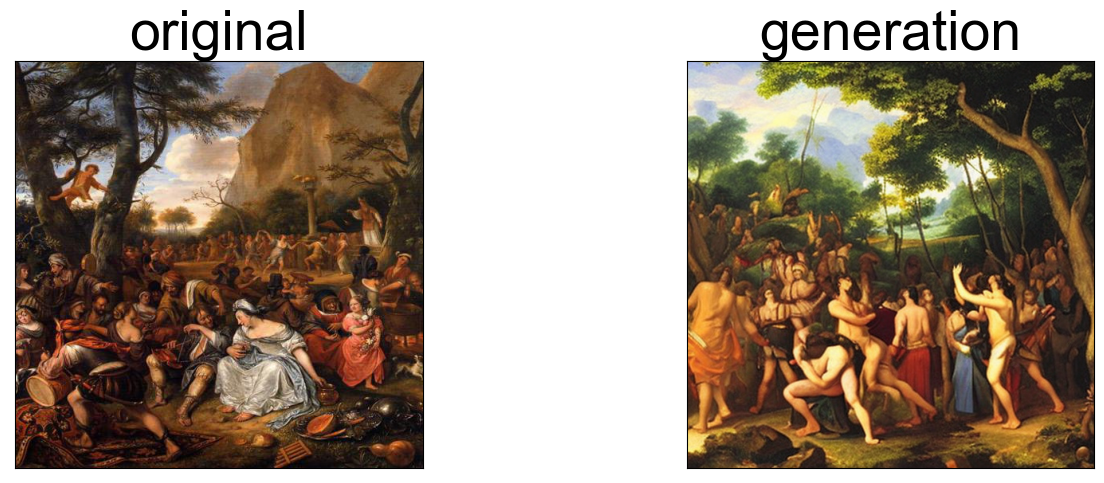

In [27]:
for idx,path in enumerate(prompt_diffusion.keys()) :
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    print(prompts['prompts'][prompts['Path']==path].values[0])
    img_test = img.imread(f'/home/jinny/projects/Art-history/02_image_resize/output/{path}')
    ax[0].imshow(img_test)
    ax[0].set_title('original',size=40)
    ax[1].imshow(model_2img(prompt_diffusion[path][0][0].reshape(1,4,64,64),model))
    ax[1].set_title('generation',size=40)
    for i in range(2) :
        ax[i].axes.xaxis.set_visible(False)
        ax[i].axes.yaxis.set_visible(False)
    artist = file_info_latents['author_name'][file_info_latents['Path']==path].values[0]
    painting = file_info_latents['painting_name'][file_info_latents['Path']==path].values[0]
    print(f'< artist - {artist} ---- painting name - {painting}>')
    plt.tight_layout() 
    plt.savefig(f'/home/jinny/projects/Art-history/Art-history/graph/supple/si04_{idx}.svg')
plt.show()